# NL / C code - Notebook 1

## imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import re


In [2]:
# Plot display tweaks

#plt.figure(figsize=(10, 5), dpi=200)


# Codes dataset fix

## convert & fix codes dataset - gzip json to csv

In [3]:

#  The json gzip ds has a known built-in bad crc at ~270k sample.
#  batch convert the valid part to csv
#  the error at ~270k is ok
#  section function commented out after the new csv is ready. 

# https://stackoverflow.com/questions/33504424/
# https://stackoverflow.com/questions/6377454

# scraper used this tokenizer:
# https://github.com/alexeygrigorev/projects/blob/master/codeforces-crawl/src/main/java/com/alexeygrigorev/codeforcescrawl/BowFeatureExtractor.java
# numbers: -NUMBER- | whitespaces:  ', ' | words: A-Z a-z _ #  | seps: - . 0 ' '

import gzip
import json

def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False


def transDBToCSV():
  
    # setup converted tokens rules
    #  can make any tokenization changes / adjustments here
    #  note: u = unicode, string encoding declarations
    tk_clean_list = ['*', ' ', '',',']
    tokens_norm = {'-NUMBER-' : '#LONGNUM#'} 
    langs_norm = {'GNU C++': u'C/C++', 'GNU C++11': u'C/C++', 'MS C++': u'C/C++', 'GNU C': u'C/C++', 'GNU C11': u'C/C++',
               'Java 8': u'Java', 'Java 7': u'Java', 
               'Python 3': u'Python', 'Python 2': u'Python', 'PyPy 2': u'Python', 'PyPy 3': u'Python',
               'FPC': u'Pascal', 'Delphi': u'Pascal',
               'MS C#': u'C#', 'Mono C#': u'C#' }
    
    # conversion buffers - json to csv
    DATA_FILENAME = 'src_code_ds/codes_refined_csv3.csv'
    entries_buf = []
    df_buf = pd.DataFrame(columns=['id', 'lang', 'source'])
    df_buf.set_index('id', inplace=True)
    
    # setup output file
    with open(DATA_FILENAME, mode='w+', encoding='utf-8') as f:
        df_buf.to_csv(f, mode='w+', index=True, header=True)
        print('file reset.')
    
    # load json ds
    codes_json = gzip.open('src_code_ds/itshared_dataset/out.json.gz', mode='r')
    #test
    #jentry = json.loads(codes_json.readline())
    #jentry['source']
    #print(jentry)
    
    # convert by batches
    i = 0
    print('converting...')
    for entry_raw in codes_json:
        #print(entry_raw)
        entry_dict = json.loads(entry_raw)
    
        # submission id
        sid = entry_dict['submission_id'] 
        sid = sid if RepresentsInt(sid) else 'bad' + str(sid)
        
        # lang
        lang = entry_dict['language']
        lang = langs_norm[lang] if lang in langs_norm else (lang)
        
        # source
        src = entry_dict['source']; 
        src = [elm.strip() for elm in src if (elm and elm.strip() not in tk_clean_list)]
        src = [(tokens_norm[tk] if tk in tokens_norm else tk) for tk in src]
        # save src as space seperated UTF string
        src = ' '.join(src) #.encode(encoding='utf-8',errors='strict')
        
        # cnt
        i = i+1
        
        # error filtering
        if i==114330 : # skip a space str based storage problematic entry
            print('---- dropping problematic entry:',entry_raw)
            continue
        if src == None or src == '':
            print('---- dropping empty entry:',entry_raw)
            continue
            
        
        # append to entries (as dict)
        entries_buf.append({'id':sid,'lang':lang,'source':src})
        
        # batch dump to file
        if i % 10000 == 0:
            #dump to file
            print('total entries:', i, '  |  current batch:', len(entries_buf))
            print('sample src:', src[:50])
            df_buf = pd.concat([pd.DataFrame([ent]) for ent in entries_buf])
            #display(df_buf)
            #print('\n\n')

            with open(DATA_FILENAME, mode='a', encoding='utf-8') as f:
                df_buf.to_csv(f, mode='a', index=False, header=False)
            entries_buf = []
            df_buf = df_buf.iloc[0:0]
            
        if i >= 120000:
            pass
            #break

    print('\n\n Done! Use csv and comment out')
            
#transDBToCSV()


# Datasets : load and review - emails and codes

## -- load emails ds --

In [4]:

# -- load emails ds --

df_ernon = pd.read_csv('email_ds/ernon/enron_emails_kagle.csv')
print('loaded df ernon emails: {}'.format(df_ernon.shape))


loaded df ernon emails: (517401, 2)


In [5]:
# quick review

display(df_ernon.tail(5))

,file,message
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...
517400,zufferli-j/sent_items/99.,Message-ID: <28618979.1075842030037.JavaMail.e...


In [6]:
# -- msg body extraction --

# extracts ernon mail body in lowercase
def msgContentExtractor(msg):

    pattern = '\n\n'
    pat_occur = 1

    i = 0
    for match in re.finditer(pattern, msg):
        if match:
            i = i+1
            if i == pat_occur:
                return msg[match.start()+2:].lower()
        else:
            print('problem with match for msg: ',msg[0:30])

# test extractor on a msg
def test_extractor():
    k = 40
    msg = df_ernon['message'][k]
    #print(msg)
    print('\n\n')
    print('============ excerpt test of a msg body =========')
    print(msgContentExtractor(msg))
#test_extractor()


# extract for entire df
df_ernon['body'] =  df_ernon['message'].apply(msgContentExtractor)
display(df_ernon.tail(4))


,file,message,body
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...,some of my position is with the alberta term b...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...,2\n\n -----original message-----\nfrom: \tdouc...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...,analyst\t\t\t\t\trank\n\nstephane brodeur\t\t\...
517400,zufferli-j/sent_items/99.,Message-ID: <28618979.1075842030037.JavaMail.e...,i think the ymca has a class that is for peopl...


## -- load codes ds --

In [7]:
# -- load codes ds --

df_codes = pd.read_csv('src_code_ds/codes_refined_csv3.csv', \
                       dtype={'id':np.int64, 'lang':'str', 'source': 'str'}) 
print('loaded df src_code_ds: {}'.format(df_codes.shape))

loaded df src_code_ds: (269871, 3)


sample entries:


,id,lang,source
0,12746065,C/C++,Author : Yash Sadhwani #include < stdio . h > ...
1,12746876,C/C++,< iostream > using namespace std ; int n ; int...
2,12747297,C/C++,< iostream > #include < sstream > #include < f...


,id,lang,source
269868,13964931,C/C++,< bits using namespace std ; int main ( ) { lo...
269869,13964942,C/C++,< iostream > #include < stdio . h > #include <...
269870,13964948,C/C++,< stdio . h > #include < string . h > #include...


excerpt from a src: < vector > using namespace std ; const int nmax = #LONGNUM# ; int a [ nmax + #LO 


data types:


id         int64
lang      object
source    object
dtype: object

Null values check:


source    0
lang      0
id        0
dtype: int64

value counts: 269871
C/C++         240942
Java           14852
Python          7150
Pascal          3688
C#              1505
Scala            377
Haskell          363
Ruby             318
JavaScript       147
PHP              147
Perl             143
Go               142
Ocaml             63
D                 34
Name: lang, dtype: int64


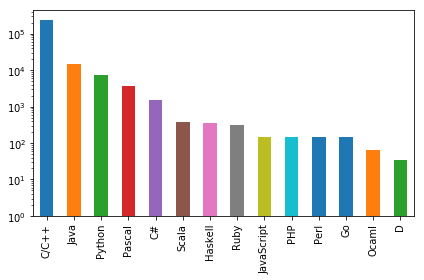

In [8]:
# quick review 


print('sample entries:\n====================')
display(df_codes.head(3))
display(df_codes.tail(3))
print('excerpt from a src:',df_codes['source'][100][20:100],'\n\n')


print('data types:\n====================')
display(df_codes.dtypes)

print('Null values check:\n====================')
display(df_codes.isnull().sum().sort_values(ascending=False))



#display(df_codes['lang'])
valc = df_codes['lang'].value_counts()
print('value counts: {}\n====================\n{}'.format(valc.sum(), valc))

df_codes['lang'].value_counts().plot(kind='bar', log='true')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


# Datasets : combine and save complete

Arranging dataframes:


,file,message,body
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...,analyst\t\t\t\t\trank\n\nstephane brodeur\t\t\...
517400,zufferli-j/sent_items/99.,Message-ID: <28618979.1075842030037.JavaMail.e...,i think the ymca has a class that is for peopl...


,id,lang,source
269869,13964942,C/C++,< iostream > #include < stdio . h > #include <...
269870,13964948,C/C++,< stdio . h > #include < string . h > #include...


,id,text,lang
517397,zufferli-j/sent_items/96.,some of my position is with the alberta term b...,NL
517398,zufferli-j/sent_items/97.,2\n\n -----original message-----\nfrom: \tdouc...,NL
517399,zufferli-j/sent_items/98.,analyst\t\t\t\t\trank\n\nstephane brodeur\t\t\...,NL
517400,zufferli-j/sent_items/99.,i think the ymca has a class that is for peopl...,NL


,id,lang,text
269867,13964927,C/C++,< stdio . h > int n t a [ #LONGNUM# ] sum = #L...
269868,13964931,C/C++,< bits using namespace std ; int main ( ) { lo...
269869,13964942,C/C++,< iostream > #include < stdio . h > #include <...
269870,13964948,C/C++,< stdio . h > #include < string . h > #include...


done!


 COMBINED DATAFRAME


,id,lang,text
269867,13964927,C/C++,< stdio . h > int n t a [ #LONGNUM# ] sum = #L...
269868,13964931,C/C++,< bits using namespace std ; int main ( ) { lo...
269869,13964942,C/C++,< iostream > #include < stdio . h > #include <...
269870,13964948,C/C++,< stdio . h > #include < string . h > #include...


data types:


id      object
lang    object
text    object
dtype: object

null values check:


text    0
lang    0
id      0
dtype: int64

lang value counts: 787272
NL            517401
C/C++         240942
Java           14852
Python          7150
Pascal          3688
C#              1505
Scala            377
Haskell          363
Ruby             318
JavaScript       147
PHP              147
Perl             143
Go               142
Ocaml             63
D                 34
Name: lang, dtype: int64


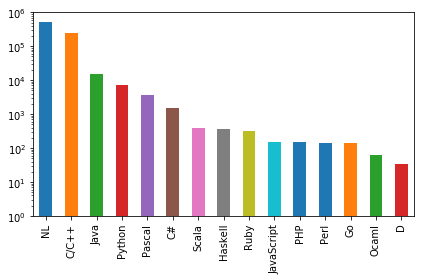

done!


In [9]:
# -- combine datasets --

def concatDfs():
    
    print('Arranging dataframes:')
    print('===========================')
    df = display(df_ernon.tail(2))
    df = display(df_codes.tail(2))

    df_mail1 = df_ernon
    df_mail1 = df_mail1.drop(columns=['message'])
    df_mail1 = df_mail1.rename(index=int, columns={'file':'id', 'body':'text'})
    df_mail1['lang']='NL'
    df_codes1 = df_codes.rename(index=int, columns={'source':'text'})

    display(df_mail1.tail(4))
    display(df_codes1.tail(4))
    print('done!')
    print('===========================')
    
    # concat fd's
    print('\n\n COMBINED DATAFRAME')
    print('===========================')
    df = pd.concat([df_mail1, df_codes1])
    
    display(df.tail(4))

    print('data types:\n====================')
    display(df.dtypes)

    print('null values check:\n====================')
    display(df.isnull().sum().sort_values(ascending=False))

    valc = df['lang'].value_counts()
    print('lang value counts: {}\n====================\n{}'.format(valc.sum(), valc))

    df['lang'].value_counts().plot(kind='bar', log='true')
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.show()
    print('done!')
    print('===========================')
    return df
 
df = concatDfs()


In [10]:

def save_complete_ds_csv(df):      
    # save to csv
    print('\n\nSaving complete dataset to csv...')
    DS_FILENAME = 'complete_dataset.csv'
    with open(DS_FILENAME, mode='w+', encoding='utf-8') as f:
        df.to_csv(f, mode='w+', index=False, header=True)
        print('done!')

#save_complete_ds_csv(df)  

# Continue in notebook 2